In [1]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np # linear algebra
import pandas as pd # data processing
from pathlib import Path
import matplotlib.pyplot as plt # import matplotlib
%matplotlib inline
import seaborn as sns # seaborn data visualizer
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
BASE_DIR = Path('../input/pima-indians-diabetes-database')

In [3]:
df = pd.read_csv('diabetes.csv')
df.head(15)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,32,1
3,89,66,23,94,28.1,0.167,21,0
4,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
6,78,50,32,88,31.0,0.248,26,1
7,115,0,0,0,35.3,0.134,29,0
8,197,70,45,543,30.5,0.158,53,1
9,125,96,0,0,0.0,0.232,54,1


In [4]:
features_list = list(df.drop(columns='Outcome').columns)
columns = list(df.columns)
print(features_list)

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [5]:
isnull = df.isnull().sum()
isnull

Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
dup = df.duplicated(subset=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
dup.value_counts()

False    768
dtype: int64

In [7]:
df.drop_duplicates(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,32,1
3,89,66,23,94,28.1,0.167,21,0
4,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63,0
764,122,70,27,0,36.8,0.340,27,0
765,121,72,23,112,26.2,0.245,30,0
766,126,60,0,0,30.1,0.349,47,1


# Multicollinearity

Multicollinearity, which is the most problematic when performing LR, is checked.

When multicollinearity exists, the explanatory power of the model decreases, and the model breaks when other variables are added.

After checking multicollinearity, features with VIF value of 10 or higher are removed.


There are several methods to remove multicollinearity. The main methods are PCA and VIF. I will use VIF

Note that you have to remove them one by one using 'loop'. Remove one and check the VIF value again.

                   Variable  Estimate       VIF
0                   Glucose  0.397688  1.298916
1             BloodPressure -0.092481  1.181550
2             SkinThickness  0.005585  1.507421
3                   Insulin -0.050649  1.424197
4                       BMI  0.220032  1.297367
5  DiabetesPedigreeFunction  0.095642  1.064108
6                       Age  0.143028  1.172888


<BarContainer object of 7 artists>

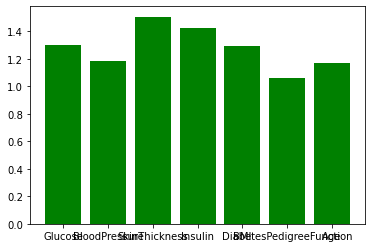

In [14]:
def standardize_var(x):
    mean = np.mean(x)
    std = np.sqrt(np.sum(np.square(x-mean))/(len(x)-1))
    return ((x-mean)/std)/np.sqrt(len(x)-1)
 
sdf = df.apply(standardize_var) 
sdf_X = sdf[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
corr = np.array(sdf_X.corr()) 
corr_inv = np.linalg.inv(corr) 
 
fit = ols('Outcome~Glucose+BloodPressure+SkinThickness+Insulin+BMI+DiabetesPedigreeFunction+Age',data=sdf).fit()
 
variables = [] 
reg_coef = [] 
vif = [] 
for i in range(len(sdf_X.columns)):
    col_name = sdf_X.columns[i]
    variables.append(col_name)
    reg_coef.append(fit.params[col_name])
    vif.append(corr_inv[i][i])
    
df_res = pd.DataFrame()
df_res['Variable'] = variables
df_res['Estimate'] = reg_coef
df_res['VIF'] = vif
left=[1,2,3,4,5,6,7]

print(df_res)
plt.bar(left,vif, tick_label = variables,width = 0.8, color = ['green'])

**Fortunately, there is no feature with a VIF greater than 10.**

# HEATMAP

**Visualize and confirm the correlation between features. Although seemingly trivial, statistical analysis is a very important task.**


If you have time, draw a scatter plot between features as well.

You can get something out of a visualized graph.

<AxesSubplot:title={'center':'Diabetes Correlation of Features'}>

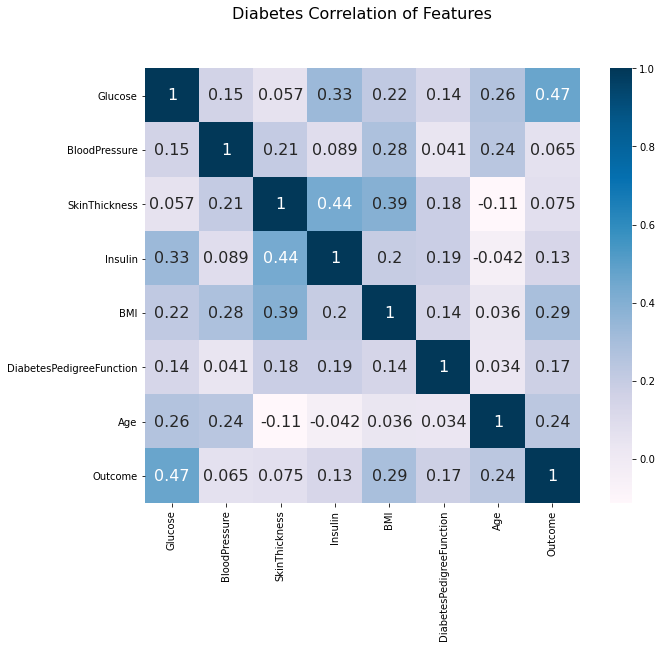

In [15]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(11, 8)) 
plt.title("Diabetes Correlation of Features", y = 1.1, size = 16) 
sns.heatmap(df.astype(float).corr(), linewidths = 0.0, vmax = 1.0, 
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

# T-test

We will first remove the variable by using the T-test.
f= variation b/w sample means/variation within the sample

In [16]:
model2 = ols('Outcome ~ Glucose+BloodPressure+SkinThickness+Insulin+BMI+DiabetesPedigreeFunction+Age', df).fit()
table2 = sm.stats.anova_lm(model2, type=2)
table2

,df,sum_sq,mean_sq,F,PR(>F)
Glucose,1.0,37.983801,37.983801,232.525439,5.272565e-46
BloodPressure,1.0,0.006706,0.006706,0.041054,8.394876e-01
SkinThickness,1.0,0.442541,0.442541,2.709104,1.001905e-01
Insulin,1.0,0.494055,0.494055,3.024454,8.242281e-02
BMI,1.0,6.708843,6.708843,41.069528,2.576181e-10
DiabetesPedigreeFunction,1.0,1.651513,1.651513,10.110069,1.534422e-03
Age,1.0,3.043190,3.043190,18.629494,1.797405e-05
Residual,760.0,124.148517,0.163353,NaN,NaN


In [17]:
df2 = table2[table2['PR(>F)'] < 0.05]
df2

,df,sum_sq,mean_sq,F,PR(>F)
Glucose,1.0,37.983801,37.983801,232.525439,5.272565e-46
BMI,1.0,6.708843,6.708843,41.069528,2.576181e-10
DiabetesPedigreeFunction,1.0,1.651513,1.651513,10.110069,1.534422e-03
Age,1.0,3.043190,3.043190,18.629494,1.797405e-05


In [18]:
features = df[['Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']]
Y = df['Outcome']
features

,Glucose,SkinThickness,BMI,DiabetesPedigreeFunction
0,148,35,33.6,0.627
1,85,29,26.6,0.351
2,183,0,23.3,0.672
3,89,23,28.1,0.167
4,137,35,43.1,2.288
...,...,...,...,...
763,101,48,32.9,0.171
764,122,27,36.8,0.340
765,121,23,26.2,0.245
766,126,0,30.1,0.349


In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(features, Y)

In [20]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [21]:
accuracy={}

# Linear Regression


In [23]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_features, train_labels)

LinearRegression()

In [24]:
accuracy["Lin R"]=model.score(train_features, train_labels)
print("LinearRegression:",model.score(train_features, train_labels))

LinearRegression: 0.27089762475649226


# Logistic Regression
**I wanted to use Backward Elimination, but gave up because the number of features was too small.**

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_features, train_labels)

LogisticRegression()

In [35]:
l=list(model.predict(train_features))
m=list(train_labels)
print("predicted value      Actual value")
for i in range(len(m)):
    print(l[i],"        ",m[i])

predicted value      Actual value
0          0
0          0
1          1
1          1
0          0
1          1
0          0
0          0
0          0
0          1
0          1
0          1
0          0
1          0
1          1
1          1
0          0
1          0
1          1
0          0
0          1
0          0
0          0
0          0
1          1
0          1
1          1
0          0
1          1
0          0
0          1
0          1
0          0
0          0
0          0
1          1
0          0
0          0
0          0
1          0
0          1
1          0
0          0
0          0
1          1
0          1
0          0
0          0
0          0
0          0
0          0
0          0
0          1
0          0
0          1
0          0
0          0
0          0
0          0
0          0
0          0
0          0
1          1
0          0
0          0
0          0
0          0
1          1
0          0
1          0
0          0
0          0
1          0
0          0
0   

In [26]:
accuracy["Log R"]=model.score(train_features, train_labels)
print("LogisticRegression:",model.score(test_features, test_labels))

LogisticRegression: 0.734375


# ARDRegression

In [20]:
from sklearn.linear_model import ARDRegression
model = ARDRegression()
model.fit(train_features, train_labels)

ARDRegression()

In [21]:
print("ARDRegression:",model.score(train_features, train_labels))

ARDRegression: 0.27999130707020814


# HuberRegressor

In [22]:
from sklearn.linear_model import HuberRegressor
model = HuberRegressor()
model.fit(train_features, train_labels)

HuberRegressor()

In [23]:
print("HuberRegressor",model.score(train_features, train_labels))

HuberRegressor 0.26288251808113805


# ridge_regression

In [24]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(train_features, train_labels, sample_weight=None)

Ridge()

In [25]:
print("ridge_regression",model.score(train_features, train_labels))

ridge_regression 0.2807944273830877


# K Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(train_features, train_labels)

KNeighborsClassifier()

In [27]:
accuracy["KNN"]=model.score(train_features, train_labels)
print("K Nearest Neighbors:",model.score(train_features, train_labels))

K Nearest Neighbors: 0.8055555555555556


# Decision Tree


In [28]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model.fit(train_features, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [29]:
accuracy["DTree"]=model.score(train_features, train_labels)
print("Decision Tree:",model.score(train_features, train_labels))

Decision Tree: 0.8142361111111112


# Support Vector Machine

In [30]:
from sklearn import svm
model = svm.SVC()
model.fit(train_features, train_labels)

SVC()

In [31]:
accuracy["SVM"]=model.score(train_features, train_labels)
print("Support Vector Machine:",model.score(train_features, train_labels))

Support Vector Machine: 0.7829861111111112


# Naïve Bayes


In [32]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_features, train_labels)

GaussianNB()

In [33]:
accuracy["NB"]=model.score(train_features, train_labels)
print("Naïve Bayes:",model.score(train_features, train_labels))

Naïve Bayes: 0.7690972222222222


# Random Forest


In [36]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(train_features, train_labels)

RandomForestRegressor()

In [37]:
l=list(model.predict(train_features))
m=list(train_labels)
print("predicted value      Actual value")
for i in range(len(m)):
    print(l[i],"        ",m[i])

predicted value      Actual value
0.03          0
0.09          0
0.94          1
0.99          1
0.0          0
0.91          1
0.14          0
0.08          0
0.03          0
0.75          1
0.73          1
0.81          1
0.05          0
0.11          0
0.98          1
0.91          1
0.01          0
0.39          0
0.83          1
0.08          0
0.86          1
0.0          0
0.08          0
0.01          0
0.98          1
0.73          1
1.0          1
0.18          0
0.81          1
0.0          0
0.73          1
0.69          1
0.03          0
0.0          0
0.07          0
0.98          1
0.05          0
0.0          0
0.01          0
0.19          0
0.79          1
0.32          0
0.01          0
0.17          0
0.99          1
0.79          1
0.03          0
0.08          0
0.0          0
0.0          0
0.01          0
0.15          0
0.77          1
0.0          0
0.8          1
0.07          0
0.0          0
0.1          0
0.1          0
0.15          0
0.03          0
0.2

In [35]:
accuracy["RF"]=model.score(train_features, train_labels)
print("Random Forest:",model.score(train_features, train_labels))

Random Forest: 0.8876557558619065


# Accuracy of ML Algorithms

In [36]:
accuracy

{'Lin R': 0.28079504111852005,
 'Log R': 0.7621527777777778,
 'KNN': 0.8055555555555556,
 'DTree': 0.8142361111111112,
 'SVM': 0.7829861111111112,
 'NB': 0.7690972222222222,
 'RF': 0.8876557558619065}

<BarContainer object of 7 artists>

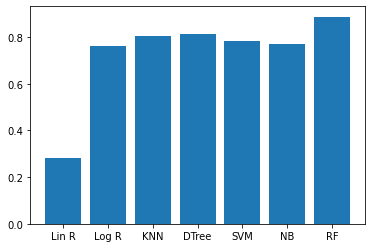

In [37]:
import matplotlib.pyplot as plt
algo=list(accuracy.keys())
accu=list(accuracy.values())
plt.bar(range(len(accuracy)),accu,tick_label=algo)

###random forest

In [ ]:
g=float(input('Enter the glucose:'))
bmi=float(input('Enter the bmi value:'))
p=float(input('Enter the pedegree function:'))
age=int(input('Enter the age:'))
phonenumber=input('Enter the whatsapp number:')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=len(train_features), n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_features, train_labels)
predicted_value=clf.predict([[g,bmi,p,age]])

In [ ]:
import pywhatkit

In [6]:
try:   
    # sending message to receiver
    # using pywhatkit
    p="+91"+phonenumber
    message="output:"+str(predicted_value)+"\naccuracy"+str(accuracy["RF"])
    pywhatkit.sendwhatmsg(p,message,22, 28)
    print("Successfully Sent!")
except:
    # handling exception
    # and printing error message
    print("An Unexpected Error!")

An Unexpected Error!
